### Imports


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from numpy.random import randn, rand

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": "Times New Roman",
})

### RFF

In [13]:
def psi(x, w, b):
    return np.sqrt(2) * np.cos(w.T@x + b)

def psi_vector(x, w, b, m):
    psi_vector = np.zeros(m)
    for i in range(m):
        x = x.reshape((-1,))
        psi_vector[i] = psi(x, w[:, i], b[:, i])
    return np.array(psi_vector)

def capital_psi(x, w, b, m, dim):
    psi = psi_vector(x, w, b, m)
    return np.kron(psi, np.eye(dim))

def phi(x, w, b, n, m, dim):
    phi = np.zeros((dim*n, dim*m))
    for i in range(0, n):
        psi = capital_psi(x[:, i], w, b, m, dim)
        phi[dim*i] = psi[0]
        phi[dim*i+1] = psi[1]
    return phi

def alpha_approx(x_vector, y, dim, m, lam, n):
    phi_ = phi(x_vector, w, b, n, m, dim)
    alpha_inv_part = np.linalg.inv(phi_.T @ phi_ + lam*np.eye(dim*m))
    y_reshaped = np.array(np.ravel([y[0], y[1]], 'F'))
    alpha = alpha_inv_part @ (phi_.T @ y_reshaped)
    return alpha

### Simulation parameters


In [14]:
time_start = 0
time_end = 100
time_step = 0.05  # this gives 2000 steps

time_series = np.arange(time_start, time_end, time_step)
number_of_timesteps = len(time_series)
init_condition = np.array([2, -2])

size_of_state = 2

noise_sigma = 0.0
g = 9.81
L = 1
K = 1
m = 1

### Harmonic Oscillator

In [15]:
def harmonic_oscillator(t, x):
    """Free Harmonic Oscillator ODE (Ordinary Differential equation)"""
    #list = [x[1], -(K/m)*x[0]]
    return np.array([x[1], -(K/m)*x[0]])

In [16]:
# init data containers
x = np.zeros((size_of_state, number_of_timesteps))
y = np.zeros((size_of_state, number_of_timesteps))

x[:, 0] = init_condition.T + np.multiply(noise_sigma, np.array(randn(size_of_state)))
y[:, 0] = harmonic_oscillator(time_start, init_condition)

#### Plot vector field

C:\Users\vilde\AppData\Local\Temp\ipykernel_10128\163565213.py:42: RuntimeWarning: invalid value encountered in scalar divide
  u_norm[i, j] = u[i, j] / V_mod
C:\Users\vilde\AppData\Local\Temp\ipykernel_10128\163565213.py:43: RuntimeWarning: invalid value encountered in scalar divide
  v_norm[i, j] = v[i, j] / V_mod
C:\Users\vilde\AppData\Local\Temp\ipykernel_10128\163565213.py:56: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_hc.show()


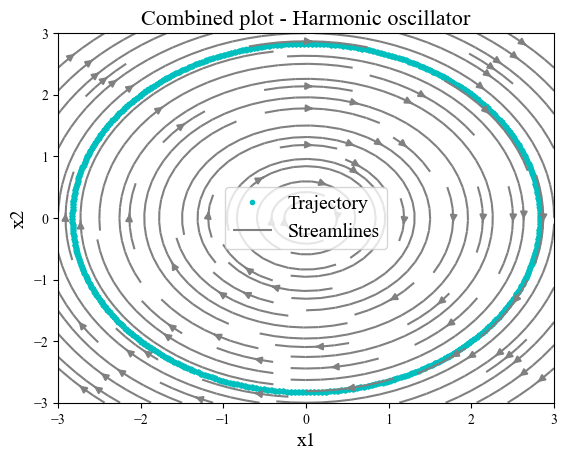

In [17]:
for i in range(0, number_of_timesteps - 1):
    timespan = [time_series[i], time_series[i + 1]]
    start_state = x[:, i]

    # Sample dynamics at current time step
    y[:, i] = harmonic_oscillator(time_series[i], start_state)
    
    # Propogate the state trajectory to next the time step using ODE-solver
    partial_trajectory = solve_ivp(harmonic_oscillator, timespan, start_state).y

    x[:, i+1] = partial_trajectory[:, -1] + np.multiply(noise_sigma, np.array(randn(size_of_state)))

lower_bound_x1 = -3
upper_bound_x1 = 3
lower_bound_x2 = -3
upper_bound_x2 = 3

num_of_points = 11

x1 = np.linspace(lower_bound_x1, upper_bound_x1, num_of_points)
x2 = np.linspace(lower_bound_x2, upper_bound_x2, num_of_points)

# Base point or starting points for each vector of the vector field
[X1, X2] = np.meshgrid(x1, x2)

# Calculate df/dt for each point
t = 0

u = np.zeros(X1.shape)
v = np.zeros(X1.shape)
u_norm = np.zeros(X1.shape)
v_norm = np.zeros(X1.shape)

for (i, j), value in np.ndenumerate(X1):
    # get velocities at each point
    Y_prime = harmonic_oscillator(t, np.array([value, X2[i, j]]))  # Harmonic
    u[i, j] = Y_prime[0]
    v[i, j] = Y_prime[1]

    # normalize vector length
    V_mod = np.sqrt(u[i, j]**2 + v[i, j]**2)
    u_norm[i, j] = u[i, j] / V_mod
    v_norm[i, j] = v[i, j] / V_mod

# Plot resulting trajectory in the data set and belonging streamlines
fig_hc = plt.figure(4)
plt.title('Combined plot - Harmonic oscillator', fontsize=16)
plt.plot(x[0, :], x[1, :], '.', linewidth=1, color='c')
plt.streamplot(X1, X2, u, v, density=1.1, color='gray')
plt.quiver(x[0, :], x[1, :], y[0, :], y[1, :], scale=700)
plt.xlabel('x1', fontsize=14)
plt.ylabel('x2', fontsize=14)
plt.legend(['Trajectory', 'Streamlines'], loc = "center" , frameon = True , prop ={'size': 14 } )
plt.xlim([lower_bound_x1, upper_bound_x1])
plt.ylim([lower_bound_x2, upper_bound_x2])
fig_hc.show()
#plt.savefig("../src/figures_plot/osc_ho.eps", format ="eps")

#### Oscillator used in regression

C:\Users\vilde\AppData\Local\Temp\ipykernel_10128\200180131.py:42: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_dho_trajectory.show()


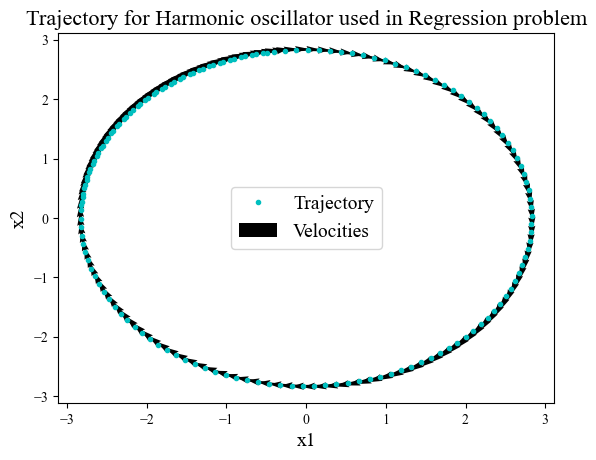

In [18]:
# Extract data series for y in the regression problem
data_series_start = np.argwhere(time_series == 15)[
    0, 0]  # to take the first element
data_series_end = np.argwhere(time_series == 22.6)[0, 0]

# Training data - init data containers
x_train = np.zeros((size_of_state, number_of_timesteps))
y_train = np.zeros((size_of_state, number_of_timesteps))

x_train = x[:,  data_series_start:data_series_end+1]
y_train = y[:,  data_series_start:data_series_end+1]

num_of_points = x_train.shape[1]
dim_of_function = y_train.shape[0]

for i in range(0, num_of_points-1):
    timespan = [time_series[i], time_series[i + 1]]
    start_state = x_train[:, i]

    # Sample dynamics at current time step
    y_train[:, i] = harmonic_oscillator(time_series[i], start_state)  # Harmonic

    # Propogate the state trajectory to next the time step using ODE-solver
    # solve_ivp is to replace the ode45 - solving odes
    partial_trajectory = solve_ivp(harmonic_oscillator, timespan, start_state).y  # Harmonic
    x_train[:, i+1] = partial_trajectory[:, -1] + \
        np.multiply(noise_sigma, np.array(randn(size_of_state)))
        
# Query only the length of the second dimension of x_train
num_of_points = x_train.shape[1]
dim_of_function = y_train.shape[0]

# Plot resulting trajectory in the data set and belonging streamlines

fig_dho_trajectory = plt.figure(5)
plt.title('Trajectory for Harmonic oscillator used in Regression problem', fontsize=16)
plt.plot(x_train[0, :], x_train[1, :], '.', linewidth=1, color='c')
plt.quiver(x_train[0, :], x_train[1, :], y_train[0, :], y_train[1, :])
plt.xlabel('x1', fontsize=14)
plt.ylabel('x2', fontsize=14)
plt.legend(['Trajectory', 'Velocities'], frameon = True , prop ={'size': 14 } )
fig_dho_trajectory.show()
#plt.savefig("../src/figures_plot/osc_ho_rff_trajectory.eps", format ="eps")

#### Regression problem

In [19]:
sigma = 5
#num_of_samples = 10
num_of_samples = 30
#w = randn(size_of_state, num_of_samples)/sigma
#b = rand(1, num_of_samples)*2*np.pi
w = np.load('RFF_parameters/w_harmonic_oscillator.npy')
b = np.load('RFF_parameters/b_harmonic_oscillator.npy')
num_of_points = x_train.shape[1]
dim_of_function = y_train.shape[0]
lambda_ = 0.000001

In [20]:
# _____________________ Regression _____________________
alpha_array_rff = alpha_approx(x_train, y_train, dim_of_function, num_of_samples, lambda_, num_of_points)
phi_ = phi(x_train, w, b, num_of_points, num_of_samples, dim_of_function)

C:\Users\vilde\AppData\Local\Temp\ipykernel_10128\4236717810.py:46: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_ho_w_rff.show()


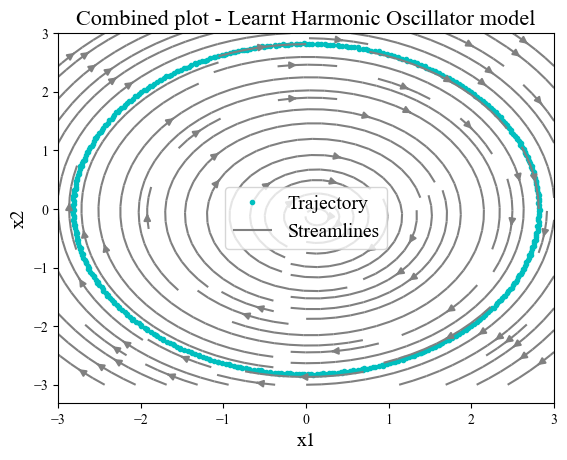

In [21]:
def learnt_model(t, x):
    func = capital_psi(x, w, b, num_of_samples, dim_of_function) @ alpha_array_rff
    return func

def learnt_model2(t, x): return np.transpose(capital_psi(x, w, b, num_of_samples, dim_of_function) @ alpha_array_rff)

init_time = 0
end_time = 45
timespan = np.array([init_time, end_time])
init_condition = np.array(([2, -2]))
t = np.linspace(init_time, end_time, 500)

# Solve diff. equations using learnt model with solve_ivp
data_series = solve_ivp(learnt_model, timespan, init_condition, t_eval=t).y

lower_bound_x1 = -3
upper_bound_x1 = 3
lower_bound_x2 = -3
upper_bound_x2 = 3

num_of_points = 11

x1 = np.linspace(lower_bound_x1, upper_bound_x1, num_of_points)
x2 = np.linspace(lower_bound_x2, upper_bound_x2, num_of_points)

# Base point or starting points for each vector of the vector field
[X1, X2] = np.meshgrid(x1, x2)

u_learnt = np.zeros(X1.shape)
v_learnt = np.zeros(X1.shape)

# for loop to get the velocity at each point witht the learnt model
for (i, j), value in np.ndenumerate(X1):
    Y_prime = learnt_model(t, np.array([value, X2[i, j]]))
    u_learnt[i, j] = Y_prime[0]
    v_learnt[i, j] = Y_prime[1]

# Plot simulated trajectory and streamslices for learnt model
fig_ho_w_rff = plt.figure(6)
plt.title('Combined plot - Learnt Harmonic Oscillator model', fontsize=16)
plt.plot(data_series[0, :], data_series[1, :], '.', linewidth = 1, color="c")
plt.streamplot(X1, X2, u_learnt, v_learnt, density = 1.1, color ='gray')
plt.xlabel('x1', fontsize=14)
plt.ylabel('x2', fontsize=14)
plt.legend(['Trajectory', 'Streamlines'], loc = "center" , frameon = True , prop ={'size': 14 } )
fig_ho_w_rff.show()
#plt.savefig("../src/figures_plot/osc_ho_rff_regression.eps", format ="eps")

In [22]:
#np.save('RFF_parameters/w_harmonic_oscillator', w)
#np.save('RFF_parameters/b_harmonic_oscillator', b)